In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from hyperparameter_optimization import generate_learning_rates
from Optimizer_Scripts.param_optimizer_helper import test_builder

In [30]:
def get_from_directory(directory):
    """Get and yield result files (in a dictionary format) 
       from a given directory
    """
    for filename in os.listdir(directory):
        #do file validation
        if (os.path.isfile(os.path.join(directory,filename))):
            with open(os.path.join(directory,filename),'r') as data:
                result = json.load(data)
            yield result
            
def get_initials(args):
    #generate the initial values to be used for the test
    if (args['loss_name']=='Rastrigin' or args['loss_name']=='Ackley'):
        initials = np.random.uniform(args['min_val'],args['max_val'],
                                     (num_test_points, args['dim']))
    elif (args['loss_name'] == 'Combustion'):
        minimizer = args['minimizer']
        initials = 1.0 + np.random.uniform(-args['vary_percent'],args['vary_percent'],
                                           (num_test_points,args['dim']))
        initals = initials * minimizer
    return initials
            
def analyze_result(result, num_test_points):
    """takes in dictionary type result and number of points to test
    """
    #get the optimizer
    try:
        var = result['print_log']
        var = result['logging']
    except:
        result['logging'] = False
        result['print_log'] = False
    args = test_builder(result)
    del args['space_search']
    #generate the initial values
    initials = get_initials(args)
    #create array of final results
    final_results = list()
    for it, x_init in enumerate(initials):
        delayer = args['delayer']
        #set the values in the optimizer for recording results
        delayer.print_log = False
        delayer.logging = True
        delayer.Optimizer.params['learning_rate'] = generate_learning_rates(
                                                         args['constant_learning_rate'], 
                                                         result['best_params']
                                                    )
        delayer.x_init = x_init 
        delayer.compute_time_series(use_delays=args['use_delays'], 
                                    maxiter=result['maxiter'],
                                    tol=args['tol'], 
                                    symmetric_delays=args['symmetric_delays'],
                                    save_time_series=False)
        delayer.delete_time_series()
        final_results.append(delayer.loss_list)
        delayer.delete_loss_list()
    #return the loss trends of all the results        
    return final_results
        
def plot_num_maps(dims,types):
    dim_map = dict()
    for it, dim in enumerate(dims):
        dim_map[str(dim)] = it
    type_map = dict()
    for it, type_ in enumerate(types):
        type_map[type_] = it
    return dim_map, type_map

def get_label_name(delayed,max_delay):
    if delayed is True:
        return "Delayed; max delay: {}".format(max_delay), "r"
    else:
        return "Undelayed", "b"
    
def get_num_plot(dim_map, type_map, dim, type_, len_dims):
    num_dim = dim_map[str(dim)]
    num_type = type_map[type_]
    num_plot = num_type*len_dims + num_dim
    return num_plot

def get_plot_title(dim_map, type_map, num, len_dims):
    reverse_dim = {v: k for k, v in dim_map.items()}
    reverse_type = {v: k for k, v in type_map.items()}
    if ((num + 1)/len_dims <= 1):
        loss_name = reverse_type[0]
        dimension = reverse_dim[num]
    else:
        dimension = reverse_dim[num-len_dims]
        loss_name = reverse_type[1]
    if (loss_name == 'Rastrigin'):
        legend_loc = 'upper right'
    elif (loss_name == 'Ackley'):
        legend_loc = 'lower left'
    else:
        legend_loc = 'upper right'
        
    return "{} in {} Dimensions".format(loss_name,dimension), legend_loc

def get_time_steps(num_steps):
    return np.arange(0,num_steps,1)
    
def get_all(directory: str, num_test_points: int, dims: list, types: list):
    dim_map, type_map = plot_num_maps(dims,types)
    num_plots = len(dims) * len(types)
    #run the tests and plot results on a whole directory
    results = get_from_directory(directory)
    fig,ax = plt.subplots(num_plots,1,figsize=(12,8*num_plots))
    #get the tests and plot them
    for result in results:
        final_loss_results = analyze_result(result, num_test_points)
        label_name, color = get_label_name(result['use_delays'], result['max_L'])
        num_plot = get_num_plot(dim_map, type_map, result['dim'], result['loss_name'], len(dims))
        #time_steps = get_time_steps(result['maxiter'])
        #ax[num_plot].plot(time_steps, final_loss_results[0],color,alpha=0.2,label=label_name)
        for it, loss_result in enumerate(final_loss_results):
            if (it == 0):
                ax[num_plot].plot(loss_result,color,alpha=0.2,label=label_name)
            else:
                ax[num_plot].plot(loss_result,color,alpha=0.2)
        #ax[num_plot].plot(final_loss_results[1:],color,alpha=0.2)
    for it, axis in enumerate(ax):
        plot_title, legend_loc = get_plot_title(dim_map, type_map, it, len(dims))
        leg = axis.legend(loc=legend_loc, prop={"size":16})
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
        axis.set_xlabel("Step", fontsize=16)
        axis.set_ylabel("Minimizer", fontsize=16)
        axis.set_title(plot_title, fontsize=20)
    plt.show()
            

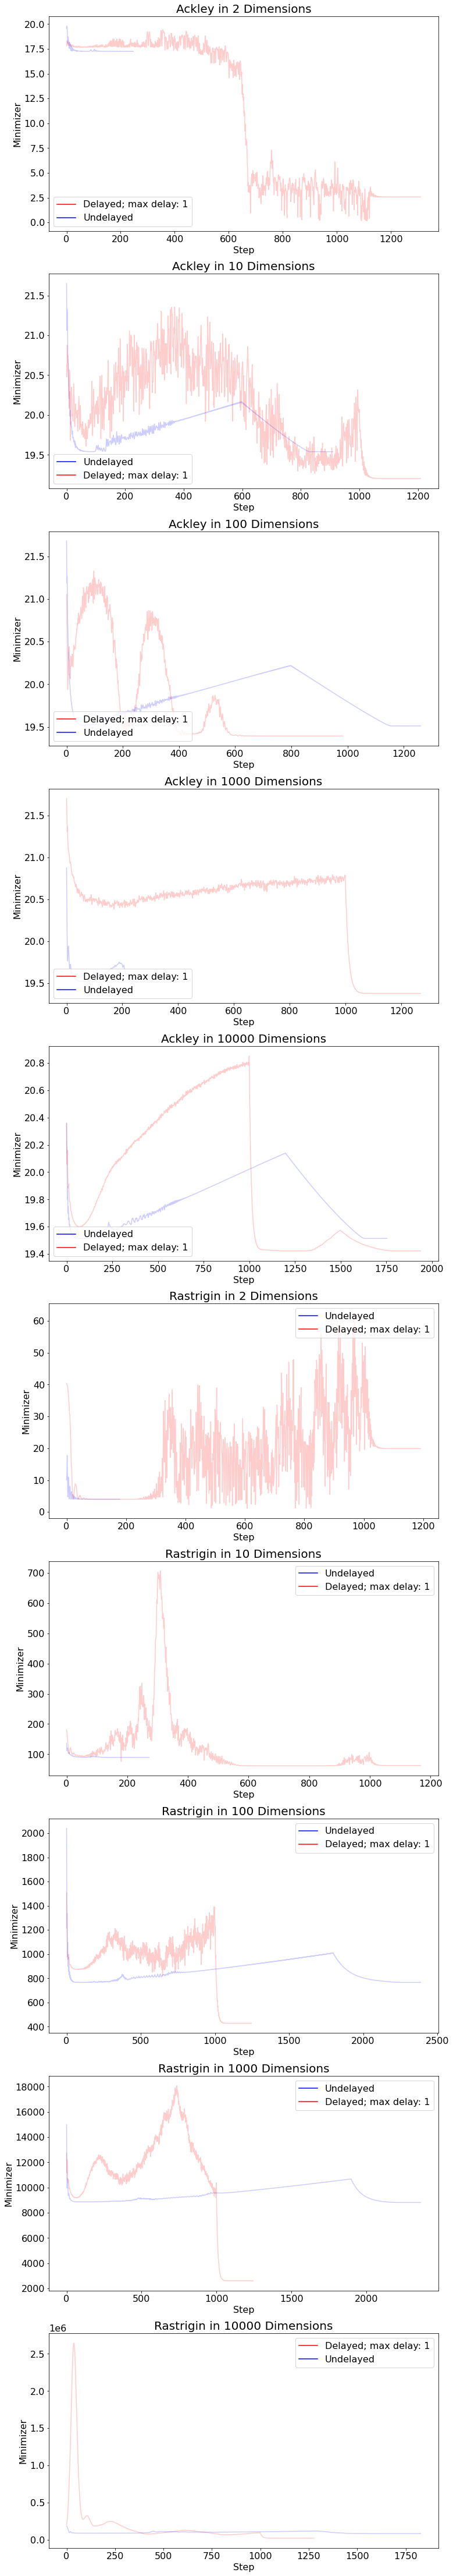

In [31]:
#get the resuts from the first test
dims = [2,10,100,1000,10000]
types = ['Ackley', 'Rastrigin']
num_test_points = 1
get_all('FinalResults0', num_test_points, dims, types)

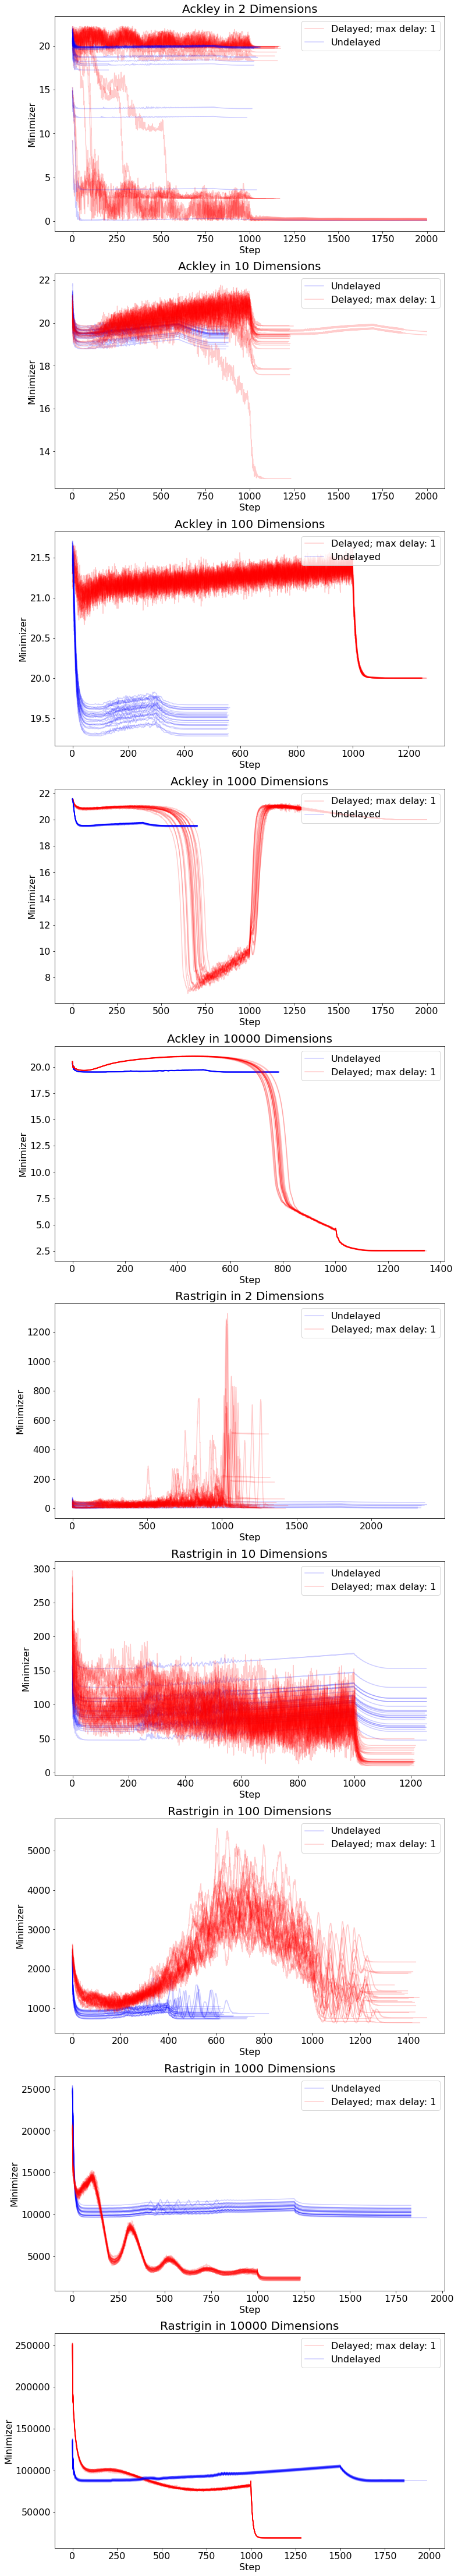

In [21]:
#get the resuts from the second test
dims = [2,10,100,1000,10000]
types = ['Ackley', 'Rastrigin']
num_test_points = 25
get_all('FinalResults1', num_test_points, dims, types)

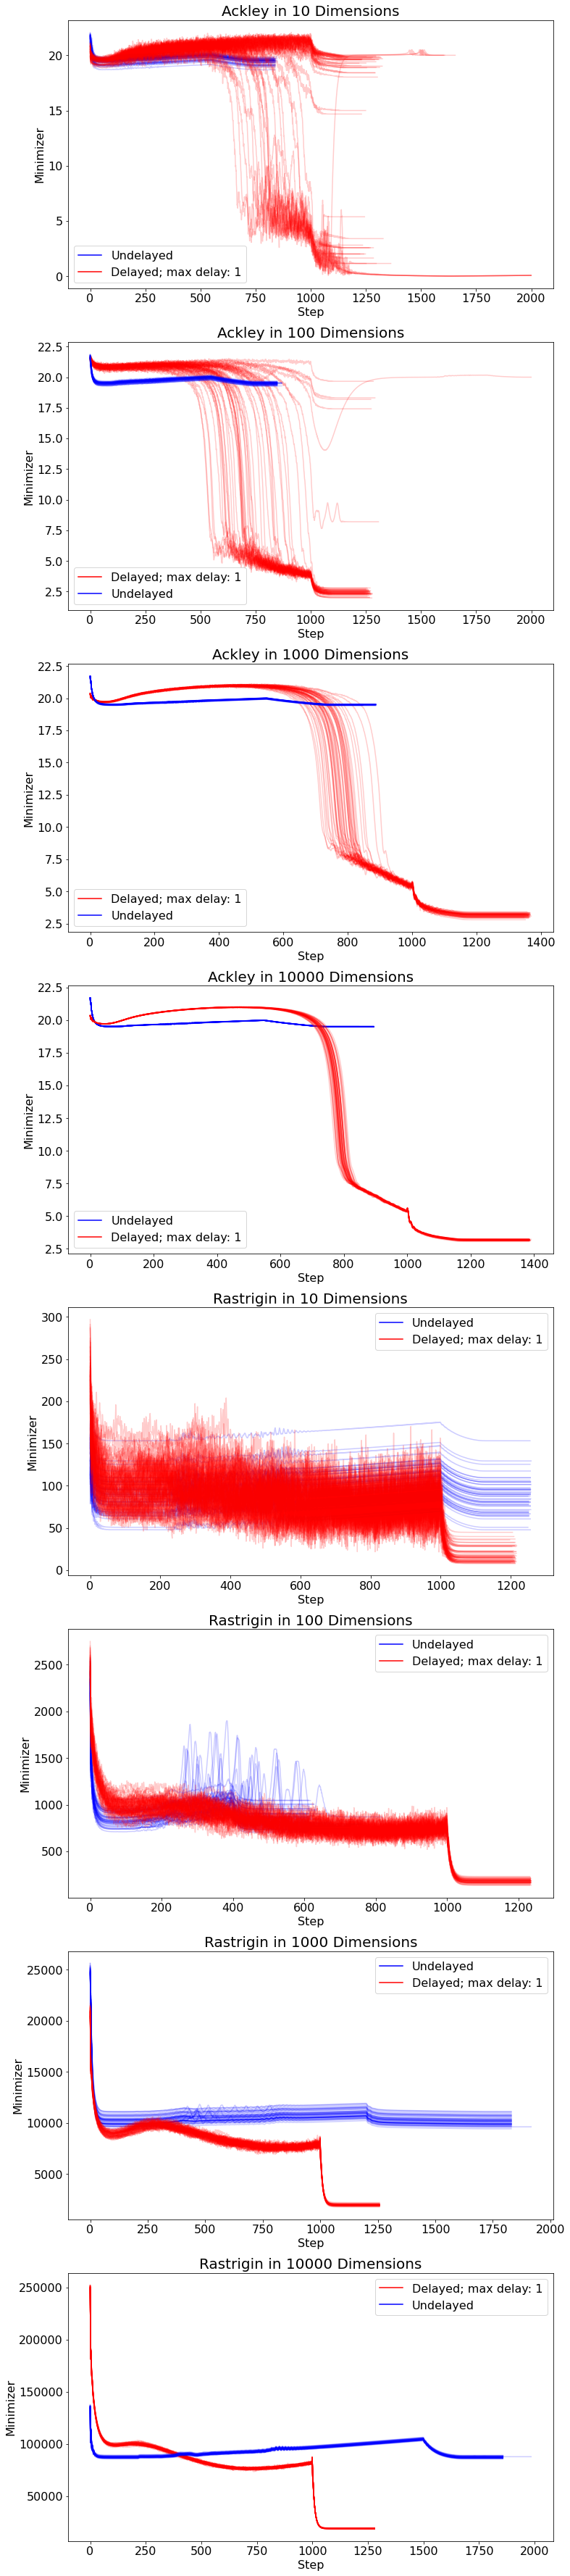

In [34]:
#get the results from the original test
dims = [10,100,1000,10000]
types = ['Ackley', 'Rastrigin']
num_test_points = 50
get_all('OriginalResults', num_test_points, dims, types)